# Исследование данных о продажах игр

В нашем распоряжении исторические данные из открытых источников о продажах игр, оценки пользователей и экспертов, жанры и платформы до 2016 года (например, Xbox или PlayStation). Выявим закономерности, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
    
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Откроем файл с данными и изучим общую информацию.

### Импортируем библиотеку pandas. Считаем данные из csv-файла в датафрейм и сохраним в переменную 'data'.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
from scipy import stats as st
import numpy as np

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


### Выведем гистограммы методом hist().

array([[<AxesSubplot:title={'center':'Year_of_Release'}>,
        <AxesSubplot:title={'center':'NA_sales'}>],
       [<AxesSubplot:title={'center':'EU_sales'}>,
        <AxesSubplot:title={'center':'JP_sales'}>],
       [<AxesSubplot:title={'center':'Other_sales'}>,
        <AxesSubplot:title={'center':'Critic_Score'}>]], dtype=object)

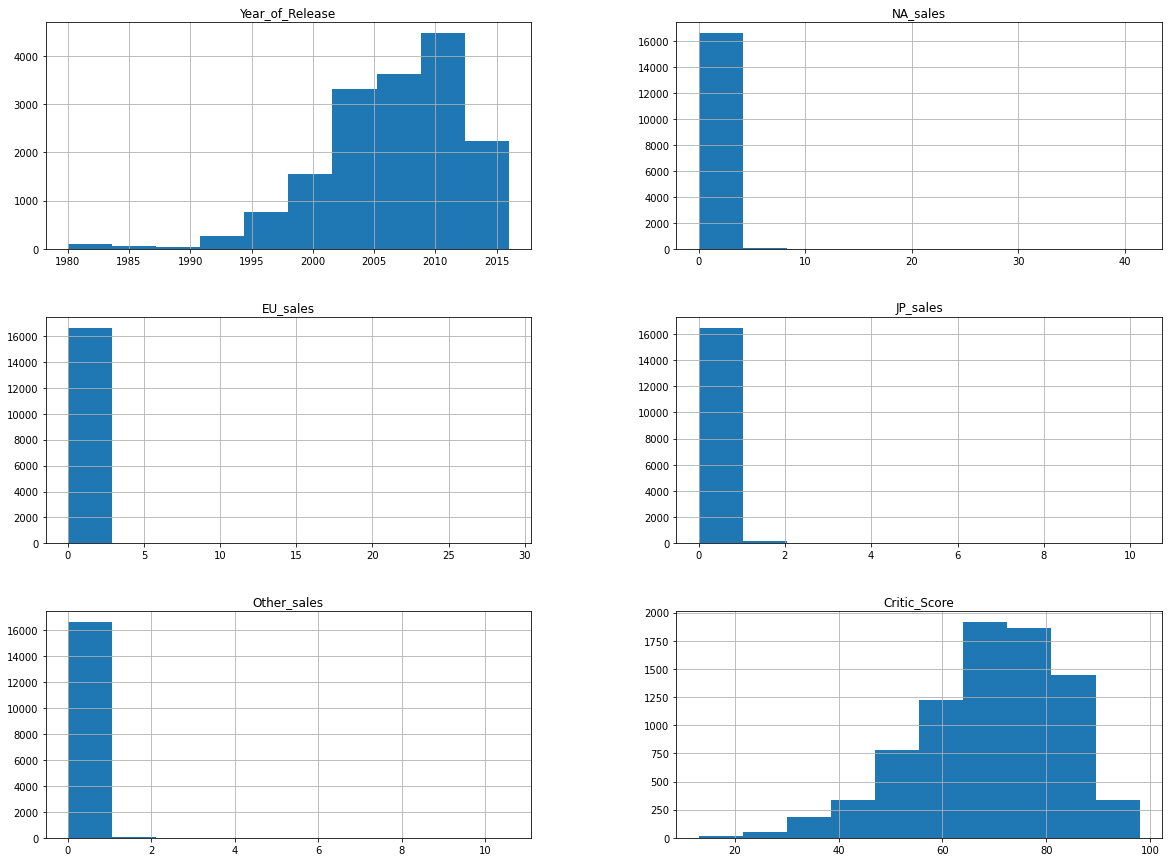

In [4]:
data.hist(figsize=(20,15))

## Предобработка данных

### Выведем на экран название колонок и проверим их на наличие пробелов, единство языка и регистра. Для удобства использования датафрейма названия колонок приведем к нижнему регистру.

In [5]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [6]:
data.columns = data.columns.str.lower()

### Выведем количество пропущенных значений для каждого столбца.

In [7]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [8]:
data.isna().mean()*100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64

В данных были обнаружены пропущенные значения. Год выпуска - 1,6%, оценка критиков - 51,3%, оценка пользователей - 40%, рейтинг от организации ESRB - 40,4%, название игры - 0,01%, жанр игры - 0,01%.

Опишем причины, которые могли привести к пропускам.
1. 'name', 'genre', 'year_of_release - пропусков менее 2%. Могли возникнуть при выгрузке данных.
2. 'critic_score',  'user_score'- пропущенные значения могли возникнуть из-за того, что игры не были подвержены оценке критиков и пользователей. Это непопулярные игры с маленькими продажами.
3. 'rating' - пропуски в колонке рейтинга ESRB возникли из-за того, что это рейтинг для США и Канады. В датасете есть игры, которые выпускаются и для других стран.

In [9]:
data.query('year_of_release.isnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


### Обработаем пропущенные значения.

1. В столбцах 'name', 'year_of_release', 'genre' пропусков менее 2%. Эти строки можем удалить.

In [10]:
data = data.dropna(subset=['name', 'year_of_release', 'genre'])

2. В столбцах 'critic_score', 'user_score' пропущенные значения заменим на '1000'. В дальнейшем анализе эти значения отфильтруем.

In [11]:
data['critic_score'] = data['critic_score'].fillna(1000)
data['user_score'] = data['user_score'].fillna(1000)

3. В столбце 'user_score' значения 'tbd' также заменим на '1000'. Аббревиатура 'tbd' означает, что игра еще не оценена достаточным количеством пользователей.

In [12]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = 1000

4. В столбце 'rating' пропущенные значения  заменим на 'unknow'. В дальнейшем анализе эти значения отфильтруем.

In [13]:
data['rating'] = data['rating'].fillna('unknow')

### Преобразуем данные в нужные типы.

Заменим тип данных на целочисленный в столбцах 'year_of_release', 'critic_score'.

In [14]:
list = ['year_of_release', 'critic_score']

for i in list:
    data[i] = data[i].astype(int)

В столбце 'user_score' заменим тип данных на 'float'.

In [15]:
data['user_score'] = data['user_score'].astype(float)

### Проверим на наличие дубликатов.

In [16]:
data.duplicated().sum()

0

Явных дубликатов не обнаружено.

### Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец 'total_sales'.

In [17]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [18]:
# Посмотрим, что осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
 11  total_sales      16444 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Проведем исследовательский анализ данных

### Исследуем, сколько игр выпускалось в разные годы.

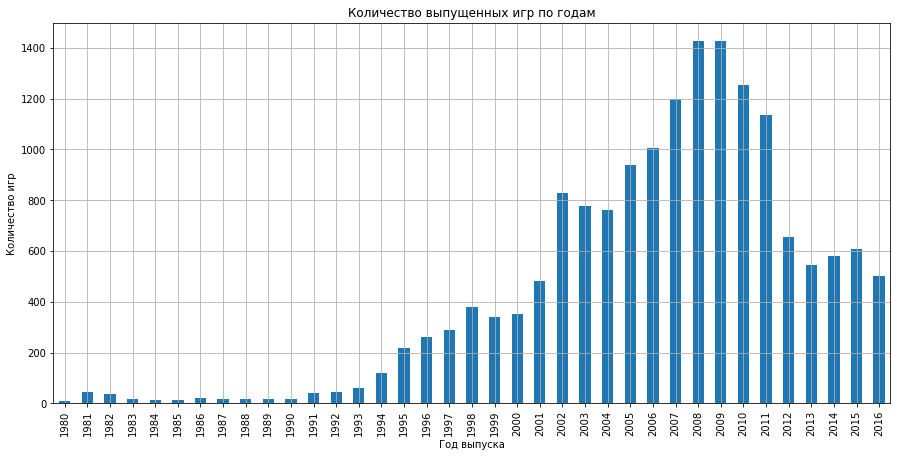

In [19]:
data.groupby('year_of_release')['name'].count().plot(kind='bar', y='count', figsize=(15,7), grid=True, title='Количество выпущенных игр по годам')
plt.ylabel('Количество игр')
plt.xlabel('Год выпуска')
plt.show()

**Вывод** С 1995 года наблюдается стремительный рост выпущенных игр, в 2008-2009 достигает своего пика. А в 2012 заметен спад в 2 и более раза.

### Исследуем, как менялись продажи по платформам.

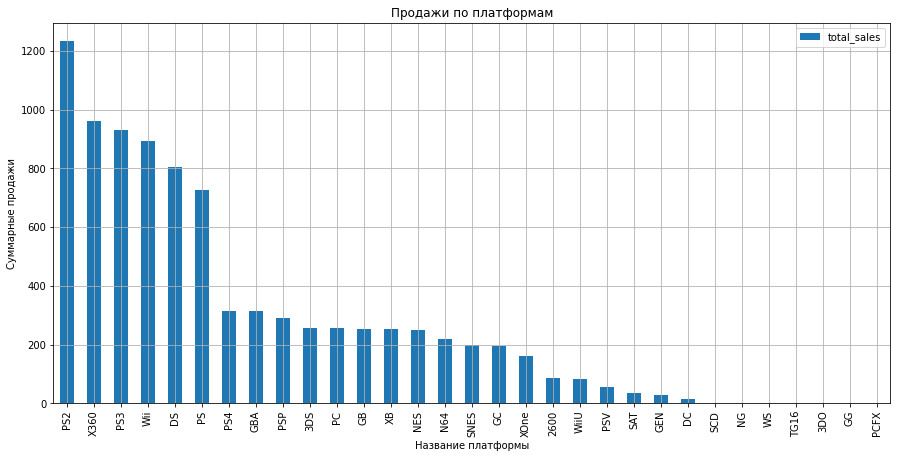

In [20]:
platform_sales = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
platform_sales.plot(kind='bar', y='total_sales', grid=True, title='Продажи по платформам', figsize=(15,7))
plt.ylabel('Суммарные продажи')
plt.xlabel('Название платформы')
plt.show()

In [21]:
platform_sales.head(10)

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


**Вывод:** Наибольшие суммарные продажи были на платформах: 'PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS	'.

Исследуем распределение суммарных продаж по годам.

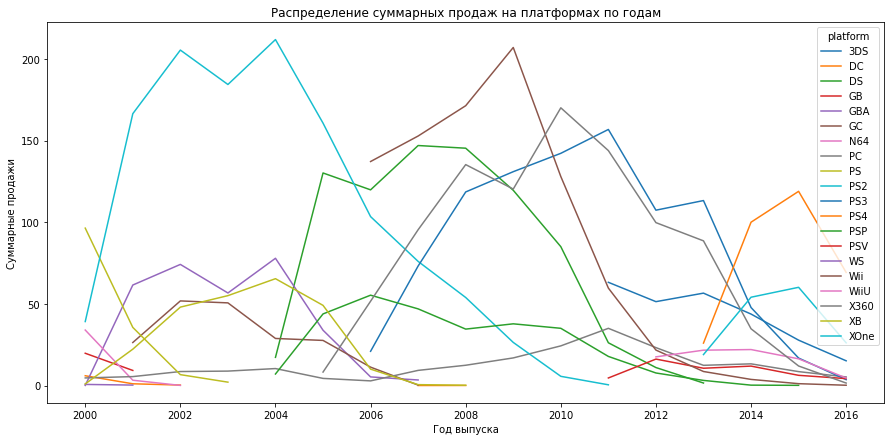

In [22]:
(
    data.query('year_of_release > 1999')
    .pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum' )
    .plot(figsize=(15,7), title='Распределение суммарных продаж на платформах по годам')
)
plt.ylabel('Суммарные продажи')
plt.xlabel('Год выпуска')
plt.show()

**Вывод:** Можно заметить, что средний цикл жизни платформы 10 лет.

### Определим акутальный период для прогноза продаж на 2017 год. 

**Актуальный период** определим с **2012 года**. При исследовании тенденций суммарных продаж на платформах по годам 2016 год учитывать не будем, так как данные за этот год неполные.

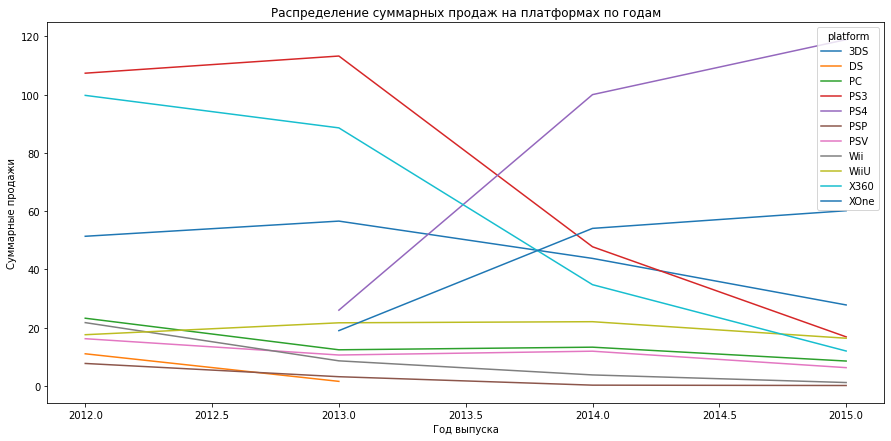

In [23]:
actual_data = data.query('year_of_release > 2011')
actual_data_platform_sale = actual_data.pivot_table(index='year_of_release', columns='platform', \
                                                    values='total_sales', aggfunc='sum' )
actual_data_platform_sale.query('year_of_release != 2016').plot(figsize=(15,7), title='Распределение суммарных продаж на платформах по годам')
plt.ylabel('Суммарные продажи')
plt.xlabel('Год выпуска')
plt.show()

In [24]:
top_platform = actual_data.pivot_table(index='platform', columns='year_of_release', \
                                                    values='total_sales', aggfunc='sum' )
top_platform

year_of_release,2012,2013,2014,2015,2016
platform,,,,,
3DS,51.36,56.57,43.76,27.78,15.14
DS,11.01,1.54,NaN,NaN,NaN
PC,23.22,12.38,13.28,8.52,5.25
PS3,107.36,113.25,47.76,16.82,3.60
PS4,NaN,25.99,100.00,118.90,69.25
PSP,7.69,3.14,0.24,0.12,NaN
PSV,16.19,10.59,11.90,6.25,4.25
Wii,21.71,8.59,3.75,1.14,0.18
WiiU,17.56,21.65,22.03,16.35,4.60


**Вывод:** На графике видно, что в 2015 году лидируют по продажам 3 платформы - 'PS4', '3DS', 'XOne'. У игр 'PS4' и 'XOne' продажи растут, а у '3DS' - падают.

### Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

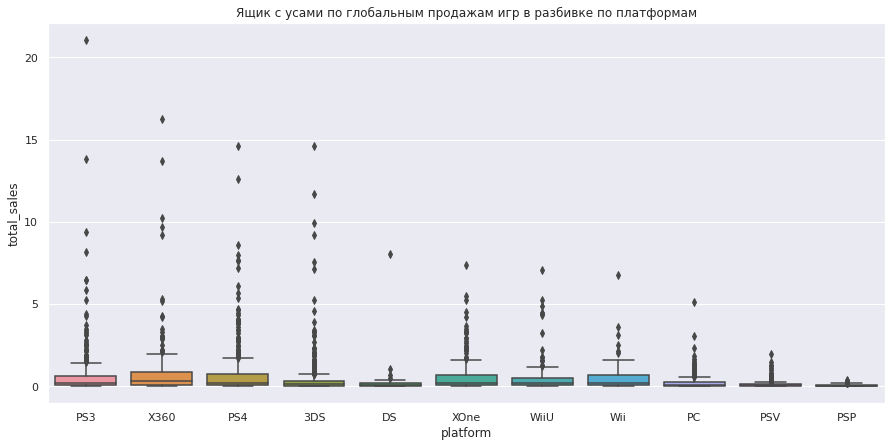

<Figure size 1080x504 with 0 Axes>

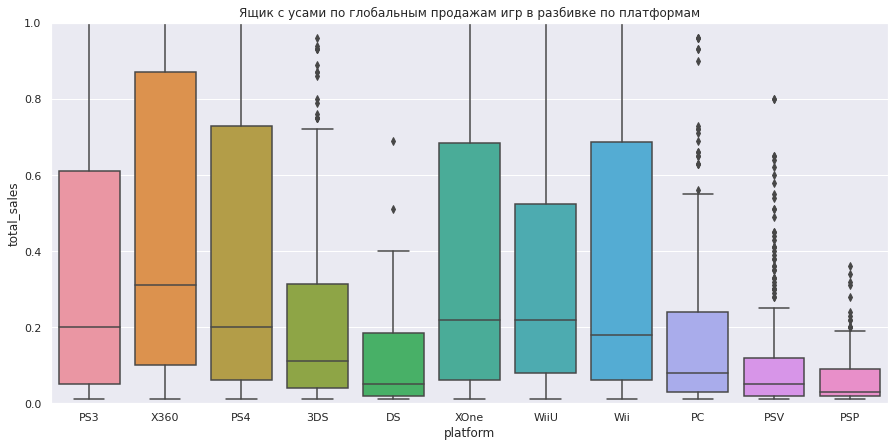

<Figure size 1080x504 with 0 Axes>

In [25]:
sns.set(rc={'figure.figsize':(15,7)})
ax = sns.boxplot(data = actual_data, y = 'total_sales', x='platform')
plt.figure(figsize=(15,7))
ax.set_title('Ящик с усами по глобальным продажам игр в разбивке по платформам')
plt.show()

ax = sns.boxplot(data = actual_data, y = 'total_sales', x='platform')
plt.ylim(0,1)
plt.figure(figsize=(15,7))
ax.set_title('Ящик с усами по глобальным продажам игр в разбивке по платформам')
plt.show()

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, что диаграммы размаха сделали в двух видах, в полном со всеми вылетами и в масштабированном виде, где хорошо видны боксплоты. </font>

In [26]:
actual_data.groupby('platform')['total_sales'].describe().sort_values(by='50%', ascending=False)

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
X360,292.0,0.810068,1.712069,0.01,0.1000,0.31,0.8700,16.27
WiiU,147.0,0.559116,1.058836,0.01,0.0800,0.22,0.5250,7.09
XOne,247.0,0.645020,1.036139,0.01,0.0600,0.22,0.6850,7.39
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.20,0.7300,14.63
PS3,493.0,0.585781,1.462855,0.01,0.0500,0.20,0.6100,21.05
Wii,54.0,0.655000,1.165447,0.01,0.0625,0.18,0.6875,6.76
3DS,396.0,0.491439,1.387161,0.01,0.0400,0.11,0.3125,14.60
PC,250.0,0.250600,0.494640,0.01,0.0300,0.08,0.2400,5.14
DS,31.0,0.404839,1.439245,0.01,0.0200,0.05,0.1850,8.06


**Вывод:** На графике "ящик с усами" можно сравнить медианы продаж по платформам за последние 5 лет. У платформы X360 медиана имеет значение 310 тыс., WiiU и XOne - 220 тыс., PS4 и PS3 - 200 тыс..

### Рассмотрим, как влияют на продажи внутри популярной платформы PS4 отзывы пользователей и критиков.

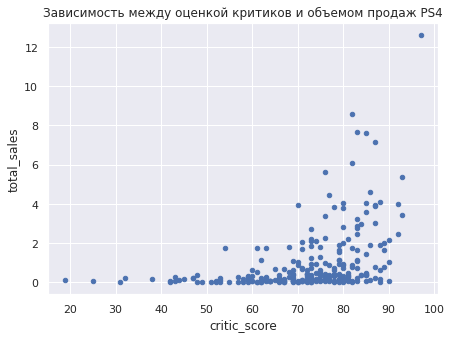

Коэффициент корреляции между оценкой критикой и объемом продаж 0.40656790206178095


In [27]:
(
    actual_data.query('critic_score != 1000 and platform == "PS4"')
    .plot(x='critic_score', y='total_sales', kind='scatter', figsize=(7,5),
          title='Зависимость между оценкой критиков и объемом продаж PS4')
)
plt.show()

corr1 = actual_data.query(
    'critic_score != 1000 and platform == "PS4"')['critic_score'].corr(actual_data.query('critic_score != 1000 \
    and platform == "PS4"')['total_sales'])

print('Коэффициент корреляции между оценкой критикой и объемом продаж', corr1)

**Вывод:** На графике можно увидеть зависимость между оценкой критиков и объемом продаж PS4. Коэффициент корреляции 0,4. Линейная зависимость есть, но небольшая.

Игры, которые получили оценку критиков ниже 70 - имеют небольшой объем продаж.

Самые высокие продажи имеют оценку критиков от 70 и более. Однако, высокая оценка не гарантирует высокие продажи. На графике видны низкие продажи при высокой оценке критиков.

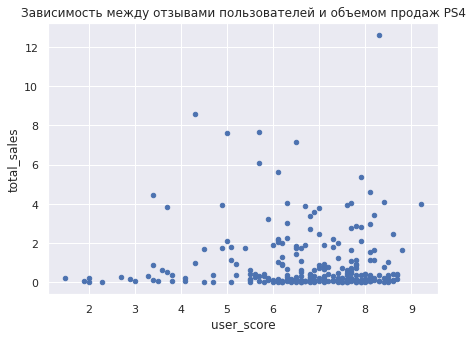

Коэффициент корреляции между отзывами пользователей и объемом продаж -0.031957110204556376


In [28]:
(
    actual_data.query('user_score != 1000 and platform == "PS4"')
    .plot(x='user_score', y='total_sales', kind='scatter',figsize=(7,5),
          title='Зависимость между отзывами пользователей и объемом продаж PS4')
)
plt.show()

corr2 = actual_data.query(
    'user_score != 1000 and platform == "PS4"')['user_score'].corr(actual_data.query('user_score != 1000 \
    and platform == "PS4"')['total_sales'])
print('Коэффициент корреляции между отзывами пользователей и объемом продаж', corr2)

**Вывод:** Коэффициент корреляции между отзывами пользователей и объемом продаж -0.03. Можно сказать, что линейной зависимости нет.

Однако на графике можно заметить, что игры имеющие оценку пользователей ниже 4 - практически не имеют высоких продаж.

Игры, которые получили оценку более 4 - имеют больше шансов на высокие продажи. Но и это не гарантия успеха, так как много игр получили высокую оценку пользователей, но объемы продаж низкие.

### Построим диаграмму рассеивания и посчитаем коэффициент корреляции между оценками критиков, отзывами покупателей и объемом продаж для других платформ.

In [29]:
actual_data['platform'].unique()

array(['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC',
       'PSV', 'PSP'], dtype=object)

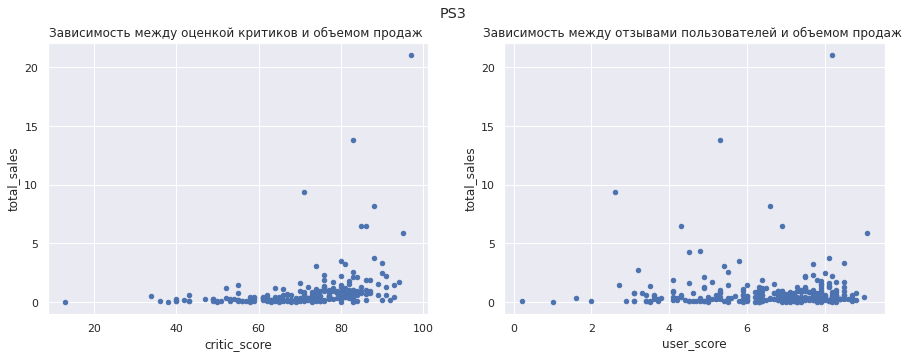

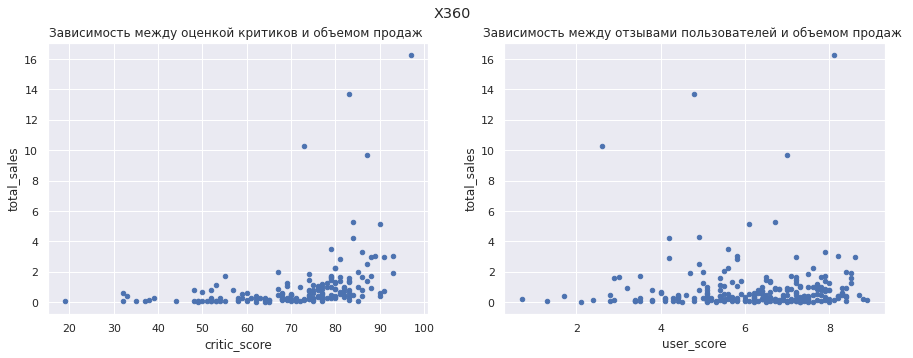

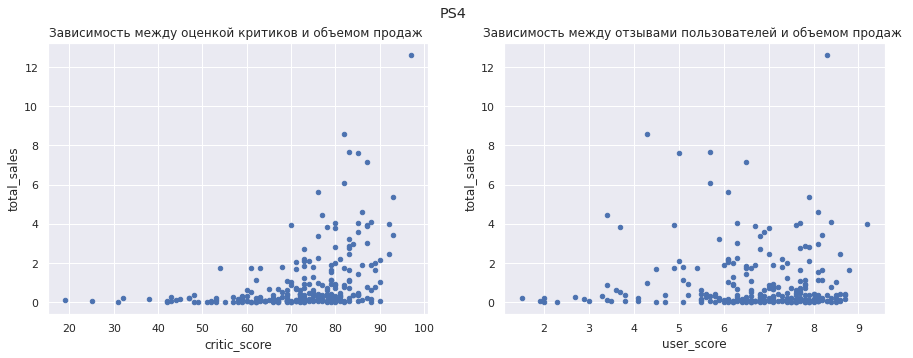

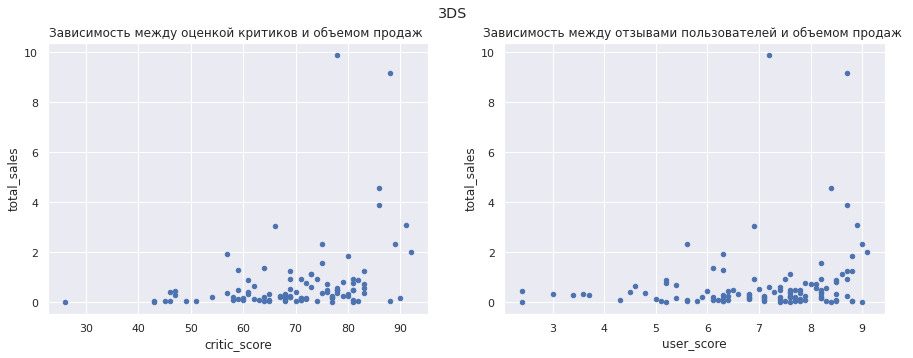

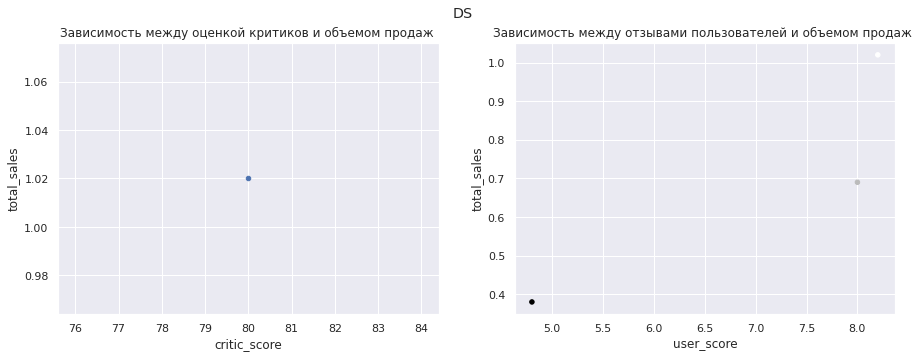

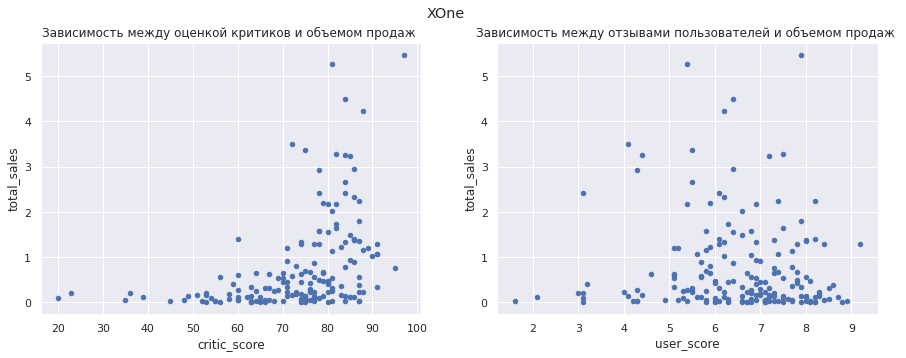

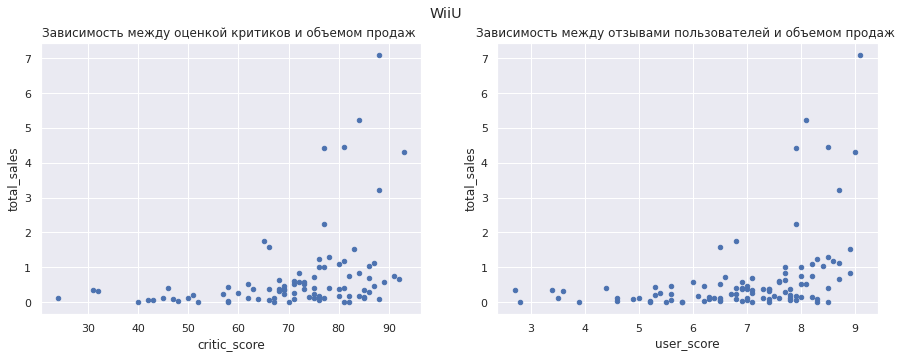

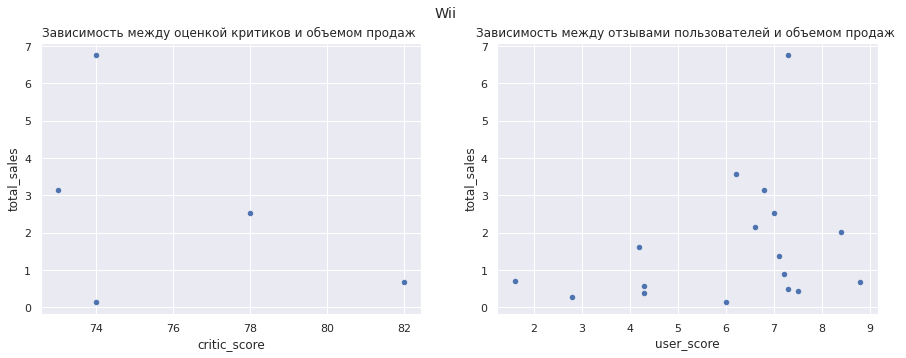

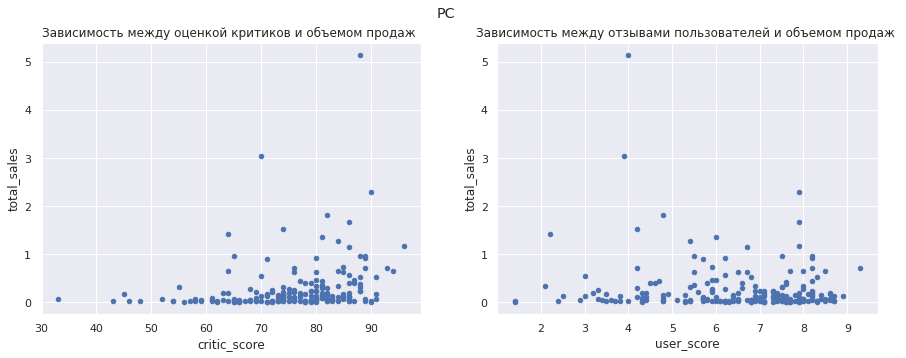

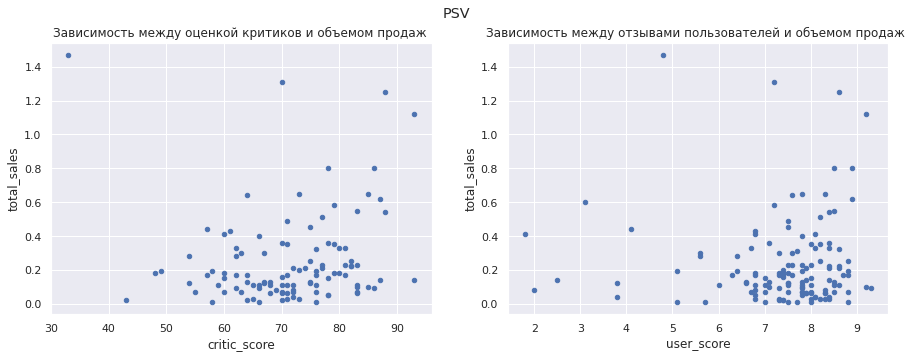

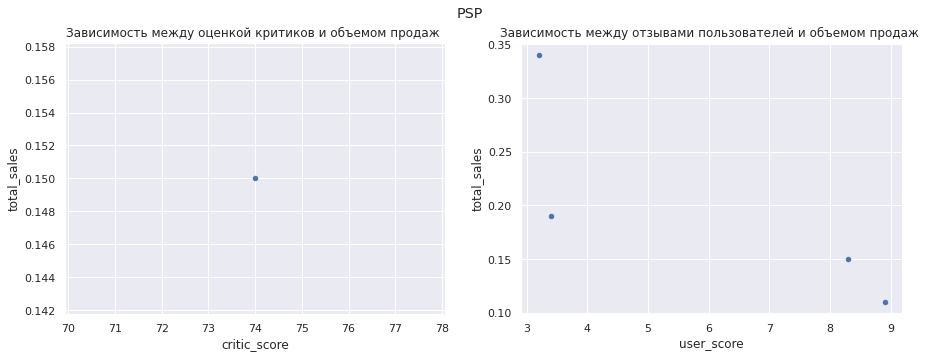

In [30]:
plats = actual_data['platform'].unique()

for plat in plats:
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    ax = ax.ravel()
    actual_data.loc[(actual_data['critic_score'] != 1000) & \
                    (actual_data['platform'] == plat)].plot(x='critic_score',
                                                            y='total_sales', 
                                                            kind='scatter', 
                                                            ax = ax[0], 
                                                            title='Зависимость между оценкой критиков и объемом продаж ')
    actual_data.loc[(actual_data['user_score'] != 1000) & \
                    (actual_data['platform'] == plat)].plot(x='user_score',
                                                            y='total_sales', 
                                                            kind='scatter', 
                                                            ax = ax[1], 
                                                            title='Зависимость между отзывами пользователей и объемом продаж ')
    corr2 = actual_data.loc[(actual_data['user_score'] != 1000) & \
                    (actual_data['platform'] == plat)]['total_sales'].corr(actual_data.loc[(actual_data['user_score'] != 1000) & \
                    (actual_data['platform'] == plat)]['user_score']) 
    fig.suptitle(plat)

In [31]:
plats = ['PS3', 'X360', 'PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV']
df = pd.DataFrame(columns=plats)

for plat in plats:
    corr1 = actual_data.loc[(actual_data['critic_score'] != 1000) & \
                    (actual_data['platform'] == plat)]['total_sales'].corr(actual_data.loc[(actual_data['critic_score'] != 1000) & \
                    (actual_data['platform'] == plat)]['critic_score'])
    corr2 = actual_data.loc[(actual_data['user_score'] != 1000) & \
                    (actual_data['platform'] == plat)]['total_sales'].corr(actual_data.loc[(actual_data['user_score'] != 1000) & \
                    (actual_data['platform'] == plat)]['user_score'])
    df.loc[:, plat] = [corr1, corr2]

df.insert(0, "Корреляция", ['Оценки критиков и продажи', 'Отзывы пользователей и продажи'])
df

,Корреляция,PS3,X360,PS4,3DS,XOne,WiiU,PC,PSV
0,Оценки критиков и продажи,0.331497,0.360573,0.406568,0.320803,0.416998,0.348380,0.237243,0.094488
1,Отзывы пользователей и продажи,-0.005144,0.006164,-0.031957,0.197583,-0.068925,0.400219,-0.121867,-0.004339


**Вывод:** На основании данных об остальных платформ можно сделать вывод, что оценка крикитов влияет на объемы продаж. Зависимость линейная, но слабая: от 0,23 до 0,41. Между отзывами пользователей и объемами продаж линейная зависимость просматривается только у платформы WiiU, у остальных платформ линейной зависимости нет.

У платформ PSP, Wii, DS оказалось недостаточно данных. Их корреляции некорректно анализировать.

### Исследуем общее распределение игр по жанрам.

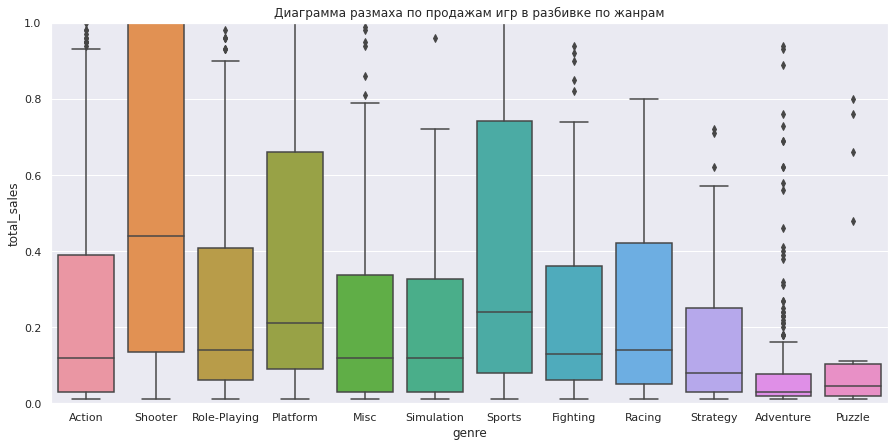

<Figure size 1080x504 with 0 Axes>

In [32]:
sns.set(rc={'figure.figsize':(15,7)})
ax = sns.boxplot(data = actual_data, y = 'total_sales', x='genre')
plt.ylim(0,1)
plt.figure(figsize=(15,7))
ax.set_title('Диаграмма размаха по продажам игр в разбивке по жанрам')
plt.show()

In [33]:
actual_data.groupby('genre')['total_sales'].agg('median').sort_values(ascending=False)

genre
Shooter         0.440
Sports          0.240
Platform        0.210
Role-Playing    0.140
Racing          0.140
Fighting        0.130
Action          0.120
Misc            0.120
Simulation      0.120
Strategy        0.080
Puzzle          0.045
Adventure       0.030
Name: total_sales, dtype: float64

**Вывод:** Самые прибыльные жанры  оказались - Shooter(440 тыс.), Sports (240 тыс.), Platform(210 тыс.).
Самые низкие продажи у жанров - Adventure (30 тыс.), Puzzle(45 тыс.) и Strategy(80 тыс.).

## Составим портрет пользователя каждого региона (NA, EU, JP)

### Определим самые популярные платформы.

Построим круговую диаграмму с разделением долей продаж в Северной Америке.

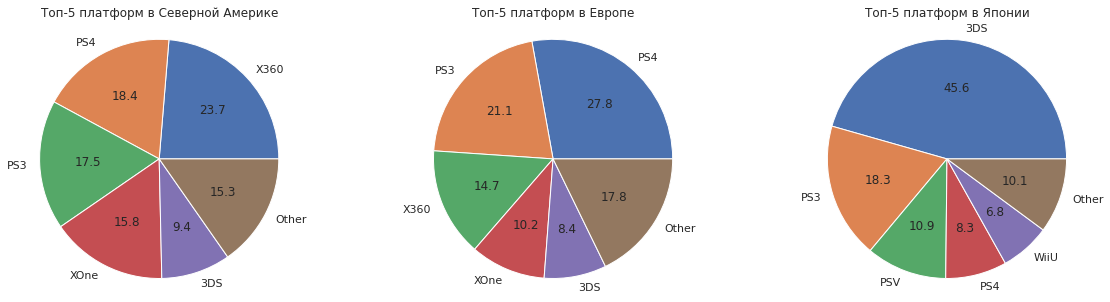

In [34]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
titles = ['Топ-5 платформ в Северной Америке', 'Топ-5 платформ в Европе', 'Топ-5 платформ в Японии']

fig, ax = plt.subplots(1,3, figsize = (20,5))
n=-1
m=-1

for region in regions:
    region_platform = actual_data.pivot_table(
        index='platform', 
        values= region, 
        aggfunc='sum').sort_values(by=region, ascending=False) 
    top_region_platform = region_platform.head().copy()
    top_region_platform.loc['Other', region] = region_platform.iloc[5:].sum()[0]
    n+=1
    m+=1
    top_region_platform.plot(kind='pie', y=region, autopct='%.1f', legend=False, title=titles[m], ax=ax[n], ylabel='', radius=1.1)

**Вывод:** В Северной Америке по продажам лидирует платформа X360, доля продаж 23.7%. PS4 на втором месте - 18.4% 
В Европе самая большая доля продаж на платформе PS4, доля продаж 27.8%.
В Японии самая большая доля продаж на платформе 3DS - 45.6%.

### Определим самые популярные жанры.

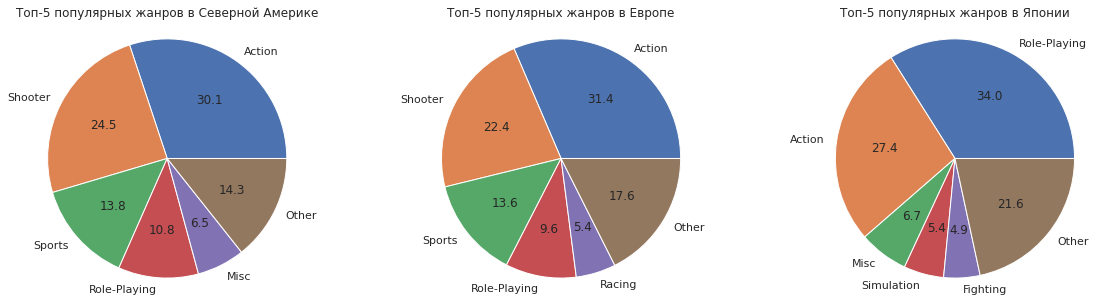

In [35]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
titles = ['Топ-5 популярных жанров в Северной Америке', 'Топ-5 популярных жанров в Европе', 'Топ-5 популярных жанров в Японии']
fig, ax = plt.subplots(1,3, figsize = (20,5))
n=-1
m=-1

for region in regions:
    region_genre = actual_data.pivot_table(
        index= 'genre', 
        values= region, 
        aggfunc= 'sum').sort_values(by=region, ascending=False)
    top_region_genre = region_genre.head().copy()
    top_region_genre.loc['Other', region] = region_genre.iloc[5:].sum()[0]
    n+=1
    m+=1
    top_region_genre.plot(kind='pie', y=region, autopct='%.1f', legend=False, title=titles[m], ax=ax[n], ylabel='', radius=1.1)

**Вывод:** В Северной Америке самый популярный жанр - Action. Доля продаж - 30.1 %. Второй по полулярности - Shooter, 24.5 %.
В Европе самый популярный жанр - также Action. Доля продаж 31.4 %. Shooter также занимает вторую позицию, 22.4 %.
В Японии занимают первое место - Role-Playing. Доля продаж 34 %. Action также на высоких позициях, 27.4 %.

### Изучим влияние рейтинга ESRB на продажи в отдельных регионах.

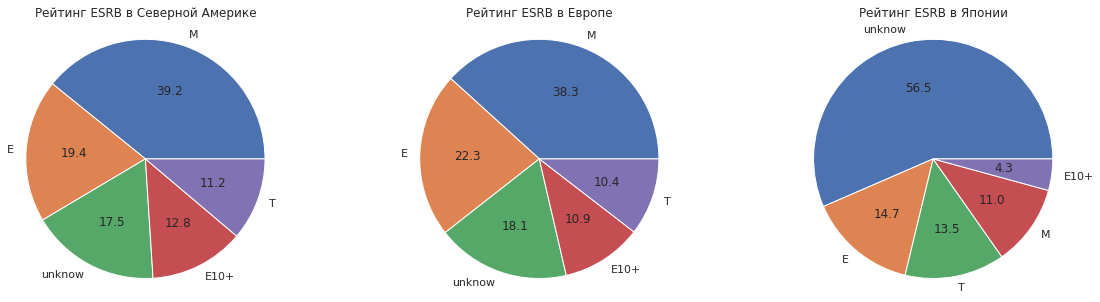

In [36]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
titles = ['Рейтинг ESRB в Северной Америке', 'Рейтинг ESRB в Европе', 'Рейтинг ESRB в Японии']
fig, ax = plt.subplots(1,3, figsize = (20,5))
n=-1
m=-1


for region in regions:
    region_esrb = actual_data.pivot_table(
        index= 'rating', 
        values= region, 
        aggfunc= 'sum').sort_values(by=region, ascending=False)
    m+=1
    n+=1
    region_esrb.plot(kind='pie', y=region, autopct='%.1f', legend=False, title=titles[m], ax=ax[n], ylabel='', radius=1.1)

**Вывод:** В Северной Америке и в Европе 38-39% продаж приходится на игры из категории 'M' (для взрослых, старше 17 лет). Категория 'E' (для всех) - занимает от 19 до 22 %.

В Японии 56,5 % продаж - рейтинг не указан. Это связно с тем, что в Японии другая рейтинговая модель. Она называется CERO. Поэтому оценивать продажи в Японии с помощью системы американской ESRB - некорректно.

## Построим и проверим гипотезы.

### Проверка гипотезы №1.

Проверим гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые. Сформулируем нулевую и альтернативную гипотезу.

H<sub>0</sub>: Cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
H<sub>1</sub>: Cредние пользовательские рейтинги платформ Xbox One и PC не одинаковые.

<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, правильно сформулированы гипотезы.</font>

In [37]:
xboxone = actual_data.loc[(actual_data['platform'] == 'XOne') & (actual_data['user_score'] != 1000)]['user_score'] 

pc = actual_data.loc[(actual_data['platform'] == 'PC') & (actual_data['user_score'] != 1000)]['user_score'] 

alpha = 0.05

results = st.ttest_ind(xboxone, pc, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Гипотезу отвергнуть не получилось. Вероятность равенства средних пользовательских рейтингов платформ Xbox One и PC - 54.8%. Это очень высокий показатель.

Проверим средние значения пользовательских рейтингов платформ Xbox One и PC.

In [38]:
print('Средние пользовательские рейтинги платформы Xbox One', xboxone.mean())
print('Средние пользовательские рейтинги платформы PC',pc.mean())

Средние пользовательские рейтинги платформы Xbox One 6.521428571428572
Средние пользовательские рейтинги платформы PC 6.4286407766990274


Средние пользовательские рейтинги платформ Xbox One и PC близкие по значению.

### Проверка гипотезы №2.

Проверим утверждение о том, средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H<sub>0</sub>: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.  
H<sub>1</sub>: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [39]:
action = actual_data.loc[(actual_data['genre'] == 'Action') & (actual_data['user_score'] != 1000)]['user_score']

sports = actual_data.loc[(actual_data['genre'] == 'Sports') & (actual_data['user_score'] != 1000)]['user_score']

alpha = 0.05

results = st.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Утверждение было верное. Вероятность того, что средние пользовательские рейтинги жанров Action и Sports одинаковое, очень маленькое.

Проверим также средние значения пользовательских рейтингов жанров Action и Sports.

In [40]:
print('Средние пользовательские рейтинги жанра Action', action.mean())
print('Средние пользовательские рейтинги жанра Sports',sports.mean())

Средние пользовательские рейтинги жанра Action 6.825047801147227
Средние пользовательские рейтинги жанра Sports 5.455897435897437


Средние пользовательские рейтинги жанров Action и Sports далеки друг от друга.

Нулевая гипотеза H<sub>0</sub> всегда формулируется так, чтобы использовать знак равенства. Альтернативная гипотеза H<sub>1</sub> формулируется исходя из H<sub>0</sub>. Это утверждение, которое принимается верным, если отбрасывается H<sub>0</sub>.

Для проверки двусторонней гипотезы был использован t-test. Этот тест был применен, так как выборки имееют более 20-30 значений, а значит имеют нормальное распределение. Также были соблюдены критерии возможности использования t-теста:
- генеральные совокупности не зависят друг от друга
- выборочные средние нормально распределены.  

Предположила, что дисперсии неравны  и указала параметр equal_var=False.
Общепринятые пороговые значения p-value — 5% и 1%. Для теста я выбрала 5%.


## Общий вывод



Исследование было проведено на основе исторических данных из открытых источников о продажах игр, оценок пользователей и экспертов, жанров и платформ до 2016 года. Цель анализа - выявить определяющие успешность игры закономерности.

1. Перед анализом была проделана предварительная обработка данных.  

В данных были обнаружены пропущенные значения. Год выпуска - 1,6%, оценка критиков - 51,3%, оценка пользователей - 40%, рейтинг от организации ESRB - 40,4%, название игры - 0,01%, жанр игры - 0,01%. Попущенные значения при анализе были отфильтрованы. Явных дубликатов обнаружено не было.

2. Исследование данных о продажах игр. 

*Исследование данных по годам*
 
С 1995 года наблюдается стремительный рост выпущенных игр, в 2008-2009 достигает своего пика. А в 2012 заметен спад в 2 и более раза. Наибольшие суммарные продажи за весь период были на платформах: 'PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS '. Средний цикл жизни одной платформы 10 лет.

 *Исследование данных по платформам*
 
Исследование данных было на основе данных с 2012 года, так как после 2011 года ситуация на рынке изменилась.
В 2015 году на рынке лидируют по продажам 3 платформы - 'PS4', '3DS', 'XOne'. У игр 'PS4' и 'XOne' продажи растут, а у '3DS' - падают. Медианное значение продаж у платформы X360 - 310 тыс., WiiU и XOne - 220 тыс., PS4 и PS3 - 200 тыс..

 *Влияние оценок критиков и пользователей на общие продажи*
 
Далее было проведено исследование о влиянии оценок критиков и пользователей на общие продажи. Было выявлено, что оценка крикитов влияет на объемы продаж. Зависимость линейная, но небольшая: от 0,23 до 0,41. Между отзывами пользователей и объемами продаж линейная зависимость просматривается только у платформы WiiU, у остальных платформ линейной зависимости нет.

 *Общее распределение игр по жанрам*
 
Самые прибыльные жанры  оказались - Shooter(440 тыс.), Sports (240 тыс.), Platform(210 тыс.).
Самые низкие продажи у жанров - Adventure (30 тыс.), Puzzle(45 тыс.) и Strategy(80 тыс.).

 *Анализ продаж по регионам: Северная Америка, Европа и Япония* 

В Северной Америке по продажам лидирует платформа X360, доля продаж 23.7%. PS4 на втором месте - 18.4%. Самый популярный жанр - Action. Доля продаж - 30.1 %. Второй по полулярности - Shooter, 24.5 %. В Северной Америке 39.2% продаж приходится на игры из категории 'M' (для взрослых, старше 17 лет). Категория 'E' (для всех) - занимает от 19.4%.

В Европе самая большая доля продаж на платформе PS4, доля продаж 27.8%. Самый популярный жанр -  Action. Доля продаж 31.4 %. Жанр shooter занимает вторую позицию, 22.4 %.  38.3% продаж приходится на игры из категории 'M' (для взрослых, старше 17 лет). Категория 'E' (для всех) - занимает 22.3 %.

В Японии самая большая доля продаж на платформе 3DS - 45.6%. Жанр Role-Playing занимает первое место - доля продаж 34 %. Action также на высоких позициях, 27.4 %. В Японии 56,5 % продаж - рейтинг не указан. Это связно с тем, что в Японии другая рейтинговая модель. Она называется CERO. Поэтому оценивать продажи в Японии с помощью системы американской ESRB - некорректно.

3. Проверка гипотез

Гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые отвергнуть не получилось. Вероятность равенства средних пользовательских рейтингов платформ Xbox One и PC - 54.8%. Это очень высокий показатель.
 
Утверждение о том, средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные, подтвердилось. Вероятность того, что средние пользовательские рейтинги жанров Action и Sports одинаковое, очень маленькое.

**Для планирования рекламных компаний рекомендую обратить внимание:**
- платформы 'PS4', 'XOne' -  лидеры рынка и их продажи растут
- жанр Shooter самый прибыльный
- рейтинг ESRB категории 'M' (для взрослых, старше 17 лет), но стоит учесть что рейтинг актуален только для США и Канады
- в США и Европе рекомендовано рекламировать платформу PS4,  в Японии - 3DS
- оценки критиков лучше учитывать, а на пользовательские отзывы обращать внимание не стоит.